In [1]:
# imports for array-handling and plotting
import numpy as np
import matplotlib
import csv
import time
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os

# keras imports for the dataset and building our neural network
import tensorflow as tf
from tensorflow.keras import models, layers, datasets, optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Impone ordinamento cartelle se hanno nomi di lunghezza diversa
def classificator (directory):
    childDirectories = next(os.walk(directory))[1]
    for x in range(len(childDirectories)):
        childDirectories[x]=int(childDirectories[x])
    childDirectories.sort()
    for x in range(len(childDirectories)):
        childDirectories[x]=str(childDirectories[x])
    return childDirectories

In [3]:
#PREAMBOLO:
# 1. versione del dataset
# 2. risorse (CPU/GPU)
# 3. augmentation sul dataset di train e/o di test
# 4. early stopping o meno

# IMPOSTO MACROPARAMETRI E VARIABILI GLOBALI
img_width, img_height = 32, 32
epoche = 10
batch_size = 100
split_per_validazione = 0.15

# 1. versione del dataset
# settare 'sceltaDataset' come "10RandomClasses", "10PoorestClasses" o "43Classes"
sceltaDataset = "43Classes"

# 2. risorse (CPU/GPU)
# settare 'programmatore' come "LN" per impostare le GPU, altrimenti qualsiasi altro modo per settare le CPU
programmatore = "LP"

# 3. augmentation sul dataset di train e/o di test
# Se desideri l'augmentation del train o nel test imposta trainAg e/o testAg come 'SI'
trainAg = 'NO'
testAg = 'NO'

# 4. early stopping o meno
# Se desideri earlyStopping imposta la variabile a 'SI'
earlyStopping = 'SI'



In [4]:
#CONTROLLI VARI

#CONTROLLO E SETTAGGIO DEL DATASET:
if sceltaDataset == "10RandomClasses":
    numeroClassi = 10
    origine = 'datasets/TrafficSignClassification-10RandomClasses'
    nb_train_samples = 33000
    nb_test_samples = 3300
elif sceltaDataset == "10PoorestClasses":
    numeroClassi = 10
    origine = 'datasets/TrafficSignClassification-10PoorestClasses'
    nb_train_samples = 4400
    nb_test_samples = 720
elif sceltaDataset == "43Classes":
    numeroClassi = 43
    origine = 'datasets/TrafficSignClassification-43Classes'
    nb_train_samples = 65000
    nb_test_samples = 9000
else:
    raise SystemExit("Dataset non riconosciuto")

#Imposto directory del dataset già decompresso dallo zip
train_data_dir = origine+'/train'
test_data_dir = origine+'/test'
label_info_dir = origine+'/labels.csv'

#Attivazione della CPU o della GPU
if programmatore == "LN":
    # for testing on GPU
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
else:
    # for testing on CPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    

#CREAZIONE PATH DI SALVATAGGIO COMUNE
creoNomeAddestramento='PersonalCNN-'+sceltaDataset+'-'+str(epoche)+'Epoche-EarlyStopping'+earlyStopping+'-TrainAg'+trainAg+'-TestAg'+testAg
pathSalvaModello=creoNomeAddestramento+'.h5'
pathStampaModello='models/modelloDi'+sceltaDataset+'.png' 
    
    
#IMPOSTO L'AUGMENTANTION:
#Default:
train_shear_range, test_shear_range = 0.0, 0.0
train_zoom_range, test_zoom_range = 0.0, 0.0
train_width_shift_range, test_width_shift_range = 0.0, 0.0
train_height_shift_range, test_height_shift_range = 0.0, 0.0
train_fill_mode, test_fill_mode = "constant", "constant" #riempe i contorni in caso di modifica, messo costant così è nero
#Attivazione augmentation se richiesta
if trainAg == 'SI':
    train_shear_range=0.15 #Distorsione angolare. Ne distorce un po' la forma, quindi la tengo
    train_zoom_range=0.15 #Zoom da applicare alla foto. Ne distorce un po' la forma, quindi la tengo
    train_width_shift_range=0.15 #spostamento orizzontale della foto per analizzarla anche da tagliata
    train_height_shift_range=0.15 #spostamento verticale della foto per analizzarla anche da tagliata
if testAg == 'SI':
    test_shear_range=0.1
    test_zoom_range=0.1
    test_width_shift_range=0.1
    test_height_shift_range=0.1

    
#IMPOSTO EARLYSTOPPING:
if earlyStopping == 'SI':
    #Implemento l'EarlyStopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
        baseline=None, restore_best_weights=False)
    checkpoint_filepath = '/tmp/checkpoint'
    epocheSalvataggio=5
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath, save_weights_only=True,
            monitor='val_loss', save_freq=epocheSalvataggio,
            save_best_only=True)
    callback = [ TensorBoard(update_freq=521),
                    EarlyStopping(monitor='val_accuracy', patience=2),
                    ModelCheckpoint("results/"+pathSalvaModello, save_best_only=True), ]
else:
    callback = None


print("Nome Addestramento:")
print(creoNomeAddestramento)

Nome Addestramento:
PersonalCNN-43Classes-10Epoche-EarlyStoppingSI-TrainAgNO-TestAgNO


In [5]:
def make_train_generator():
    # Configurazione di augmentation per il training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=split_per_validazione, #Quanto deve splittare il train per creare la validation
        shear_range=train_shear_range,
        zoom_range=train_zoom_range,
        width_shift_range=train_width_shift_range,
        height_shift_range=train_height_shift_range,
        fill_mode=train_fill_mode,
        horizontal_flip=False,
        vertical_flip=False
        #rotation_range=20, #Rotazione massima, espressa in intero. Disattiva perché i cartelli non si trovano ruotati
        )
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=int(nb_train_samples*(1-split_per_validazione)),
        class_mode='categorical',
        subset='training')
    return train_generator

def make_validation_generator():
    # Configurazione di augmentation per il training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=split_per_validazione, #Quanto deve splittare il train per creare la validation
        shear_range=train_shear_range,
        zoom_range=train_zoom_range,
        width_shift_range=train_width_shift_range,
        height_shift_range=train_height_shift_range,
        fill_mode=train_fill_mode,
        horizontal_flip=False,
        vertical_flip=False
        #rotation_range=20, #Rotazione massima, espressa in intero. Disattiva perché i cartelli non si trovano ruotati
        )
    validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=int(nb_train_samples*split_per_validazione),
        class_mode='categorical',
        subset='validation')
    return validation_generator

def make_test_generator():
    # Configurazione di augmentation per il test (solo rescaling nel caso non si voglia augmentation)
    test_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=test_shear_range,
        zoom_range=test_zoom_range,
        width_shift_range=test_width_shift_range,
        height_shift_range=test_height_shift_range,
        fill_mode=test_fill_mode,
        horizontal_flip=False,
        vertical_flip=False
        #rotation_range=20, #Rotazione massima, espressa in intero. Disattiva perché i cartelli non si trovano ruotati
        )
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=nb_test_samples,
        class_mode="categorical")
    return test_generator

#IMPORTANTE: PER MAGGIOR INFO SULL'AUGMENTATION DELLA IMAGEDATAGENERATOR, E' RIPORTATO IL LINK:
#https://fairyonice.github.io/Learn-about-ImageDataGenerator.html

In [6]:
#Importo i nomi delle classi
with open(label_info_dir, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
#elementi le prime entry che non sono dati utili
data.pop(0)
data.pop(0)
listaNomiClassi = [];
for i in range(len(data)):
    #Divido la riga per poi prendere l'elemento che mi serve
    rigaInEsame = data[i][0].split(";")
    listaNomiClassi+=[rigaInEsame[1]]

In [7]:
#import del dataset usando tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(make_train_generator, (tf.float32, tf.float32))
validation_dataset = tf.data.Dataset.from_generator(make_validation_generator, (tf.float32, tf.float32))
test_dataset = tf.data.Dataset.from_generator(make_test_generator, (tf.float32, tf.float32))

In [8]:
#ricavare immagini e label dai dataset creati con i generator
for images, labels in train_dataset.take(1):
    X_train = images.numpy()
    Y_train = labels.numpy()
    
for images, labels in validation_dataset.take(1):
    X_valid = images.numpy()
    Y_valid = labels.numpy()
    
for images, labels in test_dataset.take(1):
    X_test = images.numpy()
    Y_test = labels.numpy()

Found 54658 images belonging to 43 classes.
Found 9623 images belonging to 43 classes.
Found 8858 images belonging to 43 classes.


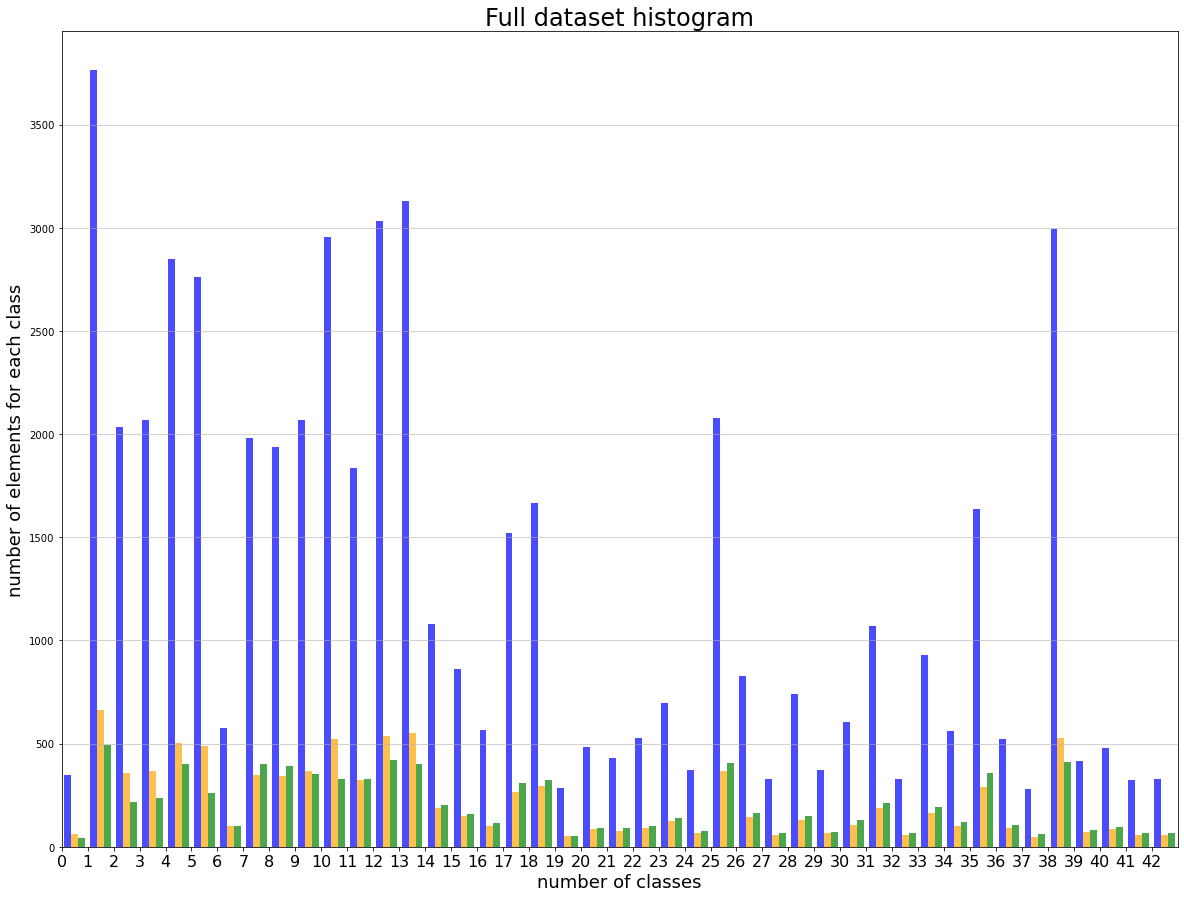

In [9]:
#HISTOGRAM REPRESENTATION
#preliminari: conversione da one-hot-encoding a interi per visionare il numero di sample per dataset
y_train = np.empty(len(Y_train),dtype=int)
y_valid = np.empty(len(Y_valid),dtype=int)
y_test = np.empty(len(Y_test),dtype=int)
for j in range(len(Y_train)):
    y_train[j]=(np.where(Y_train[j]==1)[0][0])

for j in range(len(Y_valid)):
    y_valid[j]=(np.where(Y_valid[j]==1)[0][0])
    
for j in range(len(Y_test)):
    y_test[j]=(np.where(Y_test[j]==1)[0][0])

#Quest'ultima cosa serve per la stampa finale
immaginiPerLaStampaFinale=X_test    

#genero Valori Asse X
valAsseX = []
for i in range(numeroClassi):
    valAsseX+=[i]

#creo allineamento per i risultati dell'asse x
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
    
plt.figure(num=None, figsize=(20, 15))
bins = range(numeroClassi+1)
plt.hist([y_train, y_valid, y_test], bins=bins, color=['blue', 'orange', 'green'], alpha=0.7)
bins_labels(bins, fontsize=16)
plt.xlabel("number of classes", fontsize=18)
plt.ylabel("number of elements for each class", fontsize=18)
plt.xticks(valAsseX)
plt.title('Full dataset histogram', fontsize=24)
plt.grid(axis='y', alpha=0.7)
#plt.savefig('models/hist'+sceltaDataset+'.png')
plt.show()

Digit: '1' corrisponde a 'Speed limit (30km/h)'
Digit: '5' corrisponde a 'Speed limit (80km/h)'
Digit: '10' corrisponde a 'No passing for vehicles over 3.5 metric tons'
Digit: '15' corrisponde a 'No vechiles'
Digit: '25' corrisponde a 'Road work'
Digit: '28' corrisponde a 'Children crossing'
Digit: '36' corrisponde a 'Go straight or right'
Digit: '42' corrisponde a 'End of no passing by vehicles over 3.5 metric tons'


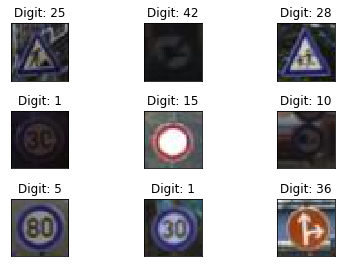

In [10]:
#Stampa prima delle classi presenti, con la corrispondente digits, e poi le immagini con la corrispondente digits
listaClassiCheVerrannoStampate = []
for i in range(9):
    #Creo la lista di classi e valori che verranno stampate
    valoreDigits=np.where(Y_train[i]==1)[0][0]
    nomeDigits=listaNomiClassi[valoreDigits]
    if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate :
        listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]

    #Stampa classica delle digits
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], interpolation='none')
    plt.title("Digit: {}".format(valoreDigits))
    plt.xticks([])
    plt.yticks([])

#Prima stampo le classi presenti, con la corrispondente digits in ordine di digits
for i in range(numeroClassi):
    for j in range(len(listaClassiCheVerrannoStampate)):
        if listaClassiCheVerrannoStampate[j][0]==i:
            print("Digit: '{}' corrisponde a '{}'".format(listaClassiCheVerrannoStampate[j][0], 
                                                          listaClassiCheVerrannoStampate[j][1]))
#Stampo i cartelli
plt.show()

In [11]:
# Creazione un modello di addestramento sequenziale
def model_sequential():
#per usare leaky relu: activation=tf.nn.leaky_relu
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(7, 7),activation=tf.nn.leaky_relu ,input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32,kernel_size=(5, 5),activation=tf.nn.leaky_relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32,kernel_size=(3, 3),activation=tf.nn.leaky_relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation=tf.nn.leaky_relu))
    model.add(Dense(numeroClassi, activation='softmax'))
    return model

In [12]:
nostroModello = model_sequential()
nostroModello.summary()
tf.keras.utils.plot_model(nostroModello, to_file=pathStampaModello)
#per usare RMSProp: optimizer=tf.keras.optimizers.RMSprop(lr=0.0001)
nostroModello.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

Epoch 1/10
547/547 - 36s - loss: 1.2475 - accuracy: 0.6617 - val_loss: 0.3857 - val_accuracy: 0.8957
Epoch 2/10
547/547 - 38s - loss: 0.2775 - accuracy: 0.9212 - val_loss: 0.2070 - val_accuracy: 0.9412
Epoch 3/10
547/547 - 38s - loss: 0.1640 - accuracy: 0.9524 - val_loss: 0.1563 - val_accuracy: 0.9570
Epoch 4/10
547/547 - 39s - loss: 0.1160 - accuracy: 0.9656 - val_loss: 0.0962 - val_accuracy: 0.9724
Epoch 5/10
547/547 - 41s - loss: 0.0815 - accuracy: 0.9750 - val_loss: 0.1355 - val_accuracy: 0.9581
Epoch 6/10
547/547 - 37s - loss: 0.0811 - accuracy: 0.9758 - val_loss: 0.0713 - val_accuracy: 0.9771
Epoch 7/10
547/547 - 41s - loss: 0.0572 - accuracy: 0.9825 - val_loss: 0.0843 - val_accuracy: 0.9731
Epoch 8/10
547/547 - 39s - loss: 0.0608 - accuracy: 0.9825 - val_loss: 0.0707 - val_accuracy: 0.9807
Epoch 9/10
547/547 - 39s - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.0338 - val_accuracy: 0.9911
Epoch 10/10
547/547 - 46s - loss: 0.0509 - accuracy: 0.9853 - val_loss: 0.0755 - val_accura

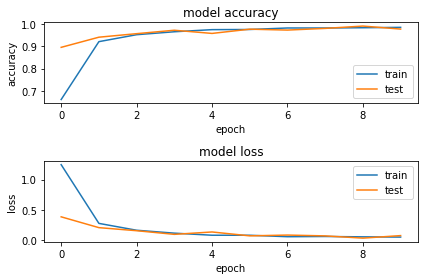

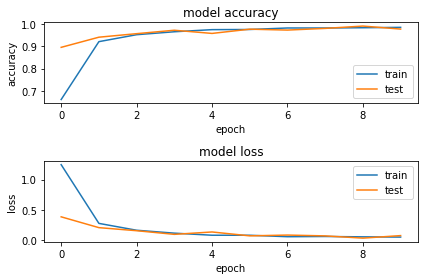

In [13]:
#Inizio a contare il tempo di addestramento
t0 = time.time()

#Avvio Addestramento
history = nostroModello.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epoche,
                    verbose=2,
                    validation_data=(X_valid, Y_valid),
                    callbacks=callback)


# Stampo l'andamento del train
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [14]:
#CALCOLO IL TEMPO DI ADDESTRAMENTO
t1 = time.time()
hours, rem = divmod(t1-t0, 3600)
minutes, seconds = divmod(rem, 60)

print("Tempo d'addestramento in secondi:")
print (t1 - t0)
print("Tempo d'addestramento in ore-minuti-secondi-scartoRimanente:")
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Tempo d'addestramento in secondi:
398.83798575401306
Tempo d'addestramento in ore-minuti-secondi-scartoRimanente:
00:06:38.84


In [15]:
# Salvataggio dell'addestramento e la sua struttura in un file esterno
# VIENE GIÀ FATTO DALL'EARLY STOPPING
if earlyStopping != 'SI':
    save_dir = "results/"
    model_name = pathSalvaModello
    model_path = os.path.join(save_dir, model_name)
    nostroModello.save(model_path)
    print('Saved trained model at %s ' % model_path)
else:
    print("Modello già precedentemente salvato dall'early stopping all'ottimo")

Modello già precedentemente salvato dall'early stopping all'ottimo


In [22]:
# Uso l'addestramento appena fatto per calcolare la loss e l'accuratezza sul test
modello_cartelli = load_model("results/"+pathSalvaModello, custom_objects={'leaky_relu': tf.nn.leaky_relu})

loss_and_metrics = modello_cartelli.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

277/277 - 2s - loss: 0.1665 - accuracy: 0.9620
Test Loss 0.1664833277463913
Test Accuracy 0.9619553089141846


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

8521  classified correctly
337  classified incorrectly

------------------------------------------------

Le prossime predizioni sono giuste

------------------------------------------------

Digit: '2' corrisponde a 'Speed limit (50km/h)'
Digit: '3' corrisponde a 'Speed limit (60km/h)'
Digit: '5' corrisponde a 'Speed limit (80km/h)'
Digit: '13' corrisponde a 'Yield'
Digit: '15' corrisponde a 'No vechiles'
Digit: '17' corrisponde a 'No entry'
Digit: '18' corrisponde a 'General caution'
Digit: '35' corrisponde a 'Ahead only'
Digit: '38' corrisponde a 'Keep right'


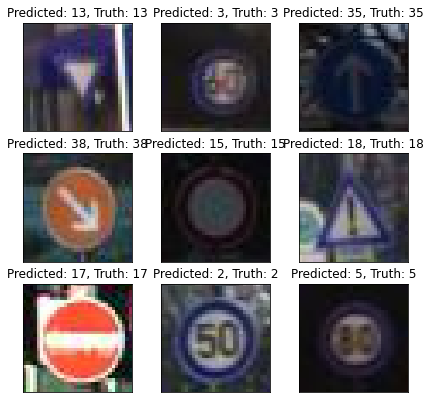


------------------------------------------------

Le prossime predizioni sono sbagliate

------------------------------------------------

Digit: '2' corrisponde a 'Speed limit (50km/h)'
Digit: '4' corrisponde a 'Speed limit (70km/h)'
Digit: '5' corrisponde a 'Speed limit (80km/h)'
Digit: '11' corrisponde a 'Right-of-way at the next intersection'
Digit: '15' corrisponde a 'No vechiles'
Digit: '21' corrisponde a 'Double curve'
Digit: '23' corrisponde a 'Slippery road'
Digit: '35' corrisponde a 'Ahead only'
Digit: '38' corrisponde a 'Keep right'
Digit: '40' corrisponde a 'Roundabout mandatory'


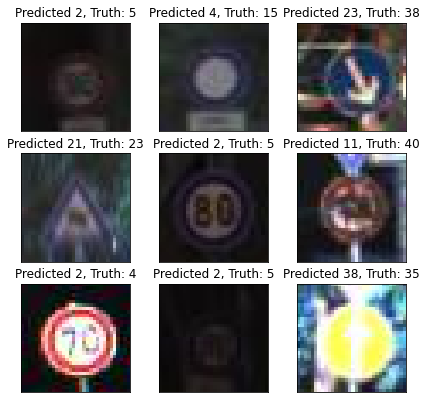

In [17]:
# Creazione delle predizioni sul test set sulla base del modello caricato
predicted_classes = nostroModello.predict_classes(X_test)

# Distinguo cosa è stato predetto bene e cosa no
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)
figure_evaluation = plt.figure()

print("\n------------------------------------------------\n")
print("Le prossime predizioni sono giuste")
print("\n------------------------------------------------\n")

listaClassiCheVerrannoStampate = []
# Stampa delle 9 predizioni corrette
for i, correct in enumerate(correct_indices[:9]):
    #Creo la lista di classi e valori che verranno stampate
    valoreDigits=predicted_classes[correct]
    nomeDigits=listaNomiClassi[valoreDigits]
    if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate :
        listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]

    #Stampa classica delle digits
    plt.subplot(6,3,i+1)
    plt.imshow(immaginiPerLaStampaFinale[correct], interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])
    
#Prima stampo le classi presenti, con la corrispondente digits in ordine di digits
for i in range(numeroClassi):
    for j in range(len(listaClassiCheVerrannoStampate)):
        if listaClassiCheVerrannoStampate[j][0]==i:
            print("Digit: '{}' corrisponde a '{}'".format(listaClassiCheVerrannoStampate[j][0], 
                                                          listaClassiCheVerrannoStampate[j][1]))
            
#Stampo i cartelli
plt.show()

print("\n------------------------------------------------\n")
print("Le prossime predizioni sono sbagliate")
print("\n------------------------------------------------\n")

listaClassiCheVerrannoStampate = []
# Stampa delle 9 predizioni incorrette
for i, incorrect in enumerate(incorrect_indices[:9]):
    #Creo la lista di classi e valori che verranno stampate
    valoreDigits=predicted_classes[incorrect]
    nomeDigits=listaNomiClassi[valoreDigits]
    if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate :
        listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]
    valoreDigits=y_test[incorrect]
    nomeDigits=listaNomiClassi[valoreDigits]
    if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate :
        listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]

    plt.subplot(6,3,i+10)
    plt.imshow(immaginiPerLaStampaFinale[incorrect], interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])
    
#Prima stampo le classi presenti, con la corrispondente digits in ordine di digits
for i in range(numeroClassi):
    for j in range(len(listaClassiCheVerrannoStampate)):
        if listaClassiCheVerrannoStampate[j][0]==i:
            print("Digit: '{}' corrisponde a '{}'".format(listaClassiCheVerrannoStampate[j][0], 
                                                          listaClassiCheVerrannoStampate[j][1]))
            
#Stampo i cartelli
plt.show()

In [18]:
confusion_matrix = tf.math.confusion_matrix(y_test, predicted_classes, num_classes=numeroClassi)
tf.print(confusion_matrix, summarize=-1)

[[44 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 481 10 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 6 213 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 235 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 11 9 0 379 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 15 9 0 234 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 101 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 20 0 2 1 0 372 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 2 0 0 384 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 3 2 344 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 329 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [19]:
# ricerca dell'elemento con più errori (se può servire)
row = 0
col = 0
item = 0
for r in range(len(confusion_matrix)):
    for c in range(len(confusion_matrix[r])):
        if (r != c and confusion_matrix[r][c] > item):
            item = confusion_matrix[r][c]
            row = r
            col = c
print("elemento con più errori è in posizione [", row, "][", col, "] con numero errori pari a:",item.numpy())

elemento con più errori è in posizione [ 29 ][ 24 ] con numero errori pari a: 22


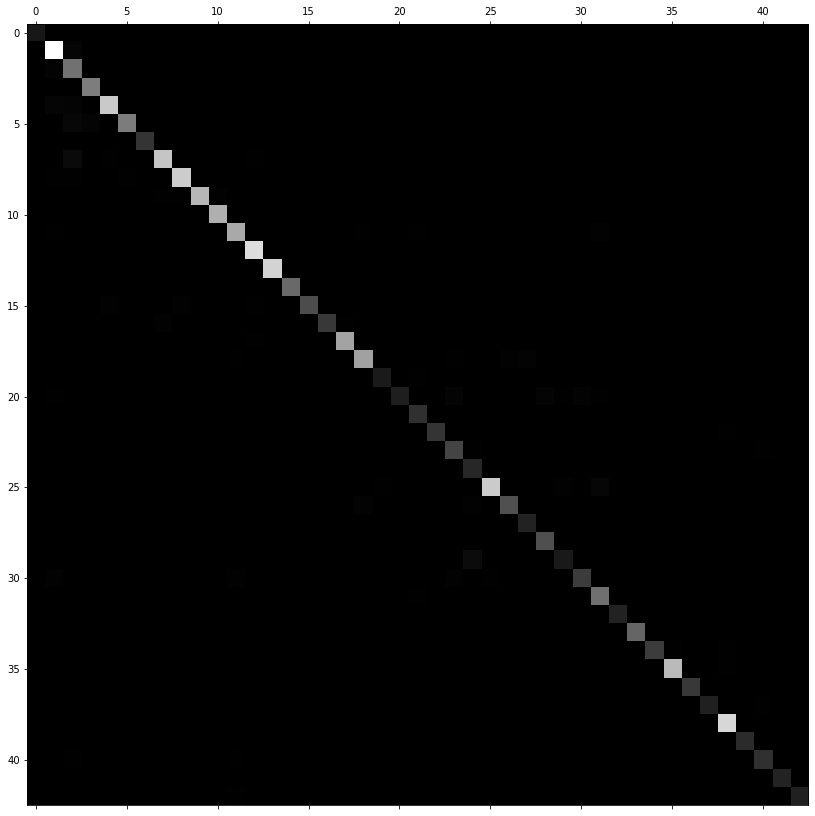

In [20]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plt.matshow(confusion_matrix.numpy(), cmap=plt.cm.gray)
#plt.savefig('models/confusion_matrix'+sceltaDataset+'.png')
plt.show()

In [21]:
print("Nome Addestramento:")
print(creoNomeAddestramento)

Nome Addestramento:
PersonalCNN-43Classes-10Epoche-EarlyStoppingSI-TrainAgNO-TestAgNO
